We import the libraries that we need:

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform

2024-02-16 11:38:11.020732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 11:38:11.020832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 11:38:11.149743: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Here, we define the paths to access to the dataset "Bone Age Datast", that previously we uploaded on Kaggle

In [2]:
dir_root = '/kaggle/input/bone-age-dataset/'
output_root = '/kaggle/working/'

training_root = 'Bone Age Training Set/Bone Age Training Set/'
validation_root = 'Bone Age Validation Set/Bone Age Validation Set/'
test_root = 'Bone Age Test Set/Bone Age Test Set/'

images_path = 'Images/'
data_path = 'Dataset.csv'
data_test_path = 'Dataset.xlsx'

#We define the paths related to the images
training_images_path = dir_root + training_root + images_path
validation_images_path = dir_root + validation_root + images_path
test_images_path = dir_root + test_root + images_path

#We define the paths related to the dataset
training_data_path = dir_root + training_root + data_path
validation_data_path = dir_root + validation_root + data_path
test_data_path = dir_root + test_root + data_test_path

We define the train, the validation and the test set:

In [3]:
train = pd.read_csv(training_data_path)
val = pd.read_csv(validation_data_path)
test= pd.read_excel(test_data_path)
#We drop the column related to the gender
train.drop(columns=["male"], inplace=True)
val.drop(columns=["male"], inplace=True)
test.drop(columns=["Sex"], inplace=True)


val.rename(columns={"Image ID": "id"}, inplace=True)
val.rename(columns={"Bone Age (months)": "boneage"}, inplace=True)
test.rename(columns={"Case ID": "id"}, inplace=True)
test.rename(columns={"Ground truth bone age (months)": "boneage"}, inplace=True)

****EDA****

In [4]:
#oldest child in the dataset
print("Max age: " + str(train["boneage"].max()) + " months")

#youngest child in the dataset
print("Min age: " + str(train["boneage"].min()) + " months")

#mean age is
mean_bone_age = train["boneage"].mean()
print("mean: " + str(mean_bone_age))

#median bone age
print("median: " +str(train["boneage"].median()))

#standard deviation of boneage
std_bone_age = train["boneage"].std()

Max age: 228 months
Min age: 1 months
mean: 127.3207517246848
median: 132.0


Text(0.5, 1.0, 'Distribution of the children for the age')

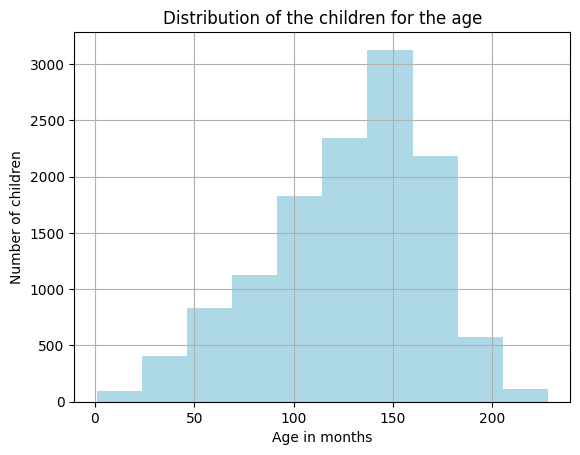

In [5]:
train["boneage"].hist(color = "lightblue")
plt.xlabel("Age in months")
plt.ylabel("Number of children")
plt.title("Distribution of the children for the age")

In [6]:
def generate_path(row):
    return training_images_path + str(row['id']) + '.png'

train['path'] = train.apply(generate_path, axis=1)

(2920, 2320, 3)


Text(0.5, 1.0, 'y = 180')

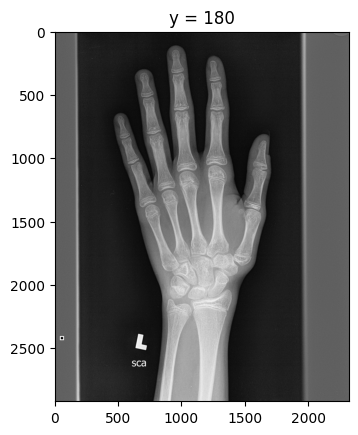

In [7]:
index =1263

image_path = train.loc[:,"path"][index]
#We upload and read the image
img = cv2.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.title("y = " +str(np.squeeze(train.iloc[index, 1])))

In [8]:
def generate_path(row):
    return validation_images_path + str(row['id']) + '.png'

val['path'] = val.apply(generate_path, axis=1)

In [9]:
def generate_path(row):
    return test_images_path + str(row['id']) + '.png'

test['path'] = test.apply(generate_path, axis=1)

**Preprocessing**

We define a function to apply the Contrast Limited Adaptive Histogram Equalization (CLAHE) to our images, in order to enhance the contrast of it

In [10]:
def apply_clahe(image, cliplimit=4.0, tilegridsize=(8,8)):
    image = image.astype("uint8")
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=tilegridsize)
    clahe_image = clahe.apply(image[:,:,0]) 
    
    return np.expand_dims(clahe_image, axis=-1)

This code initializes an ImageDataGenerator object for data augmentation purposes during training. Here's a breakdown of its parameters:

- rotation_range: it randomly rotates the image with a range that varies from -45 to +45 degrees.

- width_shift_range and height_shift_range: they define the range for randomly shifting the width and height dimensions of the images, respectively. 

- zoom_range: it specifies the range for random zooming applied to the images. 

- horizontal_flip and vertical_flip: they indicate whether horizontal and vertical flips should be applied to the images, 

- preprocessing_function: it applies the CLAHE function

In [11]:
image_augmentator_train=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=apply_clahe
)

The ImageDataGenerator object for data augmentation related to the validation e test sets applies only the CLAHE function to the images

In [12]:
image_augmentator_test=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=apply_clahe
)

We set up a data generator that reads images from file paths specified in the "path" column and their corresponding labels from the "boneage" column.

In [13]:
batch_size = 40

train_dataset = image_augmentator_train.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col="path",
    y_col="boneage",
    target_size=(256, 256),                             # Resize images to (256, 256)
    color_mode='grayscale',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    classes=None,
    class_mode='other',
    rescale=1/255)                                     # Rescale pixel values to range [0, 1]

val_dataset = image_augmentator_test.flow_from_dataframe(
    dataframe=val,
    directory=None,
    x_col="path",
    y_col="boneage",
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    classes=None,
    class_mode='other',
    rescale=1/255)

test_dataset = image_augmentator_test.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col="path",
    y_col="boneage",
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    classes=None,
    class_mode='other',
    rescale=1/255)

Found 12611 validated image filenames.
Found 1425 validated image filenames.
Found 0 validated image filenames.


/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 200 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


*We run again the process to create the test dataset only because it doesn't work at the first run

In [14]:
def generate_path(row):
    return test_images_path + str(row['id']) + '.png'

test['path'] = test.apply(generate_path, axis=1)

In [15]:
test_dataset = image_augmentator_test.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col="path",
    y_col="boneage",
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    classes=None,
    class_mode='other',
    rescale=1/255)

Found 200 validated image filenames.


In [16]:
train_steps = int(np.ceil(len(train)/batch_size))
val_steps = int(np.ceil(len(val)/batch_size))
test_steps = int(np.ceil(len(test)/batch_size))

****INCEPTION V4****

We define an Inception_V4 network

In [17]:
def conv2d_bn(X_input, filters, kernel_size, strides, padding='same', activation=None,
              name=None):
    
    # defining name basis
    conv_name_base = 'conv_'
    bn_name_base = 'bn_'

    X = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides,
               padding = padding, name = conv_name_base + name,
               kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis = 3, name = bn_name_base + name)(X)
    if activation is not None:
        X = Activation(activation)(X)
    return X

In [18]:
def stem_block(X_input):

    # First conv
    X = conv2d_bn(X_input, filters = 32, kernel_size = (3, 3), strides = (2, 2),
                  padding = 'valid', activation='relu', name = 'stem_1th')

    # Second conv
    X = conv2d_bn(X, filters = 32, kernel_size = (3, 3), strides = (1, 1),
                  padding = 'valid', activation='relu', name = 'stem_2nd')

    # Third conv
    X = conv2d_bn(X, filters = 64, kernel_size = (3, 3), strides = (1, 1),
                  padding = 'same', activation='relu', name =  'stem_3rd')

    # First branch: max pooling
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'stem_1stbranch_1')(X)

    # Second branch: conv
    branch2 = conv2d_bn(X, filters = 96, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'stem_1stbranch_2')

    X = tf.concat(values=[branch1, branch2], axis=3)

    # First branch: 2 convs
    branch1 = conv2d_bn(X, filters = 64, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_1_1')
    branch1 = conv2d_bn(branch1, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'valid', activation='relu',
                        name = 'stem_2ndbranch_1_2')

    # Second branch: 4 convs
    branch2 = conv2d_bn(X, filters = 64, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_2_1')
    branch2 = conv2d_bn(branch2, filters = 64, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_2_2')
    branch2 = conv2d_bn(branch2, filters = 64, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_2_3')
    branch2 = conv2d_bn(branch2, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'valid', activation='relu',
                        name = 'stem_2ndbranch_2_4')

    X = tf.concat(values=[branch1, branch2], axis=3)

    # First branch: conv
    branch1 = conv2d_bn(X, filters = 192, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'stem_3rdbranch_1')

    # Second branch: max pooling
    branch2 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'stem_3rdbranch_2')(X)

    X = tf.concat(values=[branch1, branch2], axis=3)

    return X

In [19]:
def inception_a_block(X_input, base_name):


    # Branch 1
    branch1 = AveragePooling2D(pool_size = (3, 3), strides = (1, 1),
                           padding = 'same', name = base_name + 'ia_branch_1_1')(X_input)
    branch1 = conv2d_bn(branch1, filters = 96, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_1_2')

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 96, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_2_1')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 64, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_3_2')

    # Branch 4
    branch4 = conv2d_bn(X_input, filters = 64, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_4_1')
    branch4 = conv2d_bn(branch4, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_4_2')
    branch4 = conv2d_bn(branch4, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_4_3')

    X = tf.concat(values=[branch1, branch2, branch3, branch4], axis=3)

    return X

In [20]:
def inception_b_block(X_input, base_name):


    # Branch 1
    branch1 = AveragePooling2D(pool_size = (3, 3), strides = (1, 1),
                           padding = 'same', name = base_name + 'ib_branch_1_1')(X_input)
    branch1 = conv2d_bn(branch1, filters = 128, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_1_2')

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 384, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_2_1')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 192, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 224, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_3_2')
    branch3 = conv2d_bn(branch3, filters = 256, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_3_3')

    # Branch 4
    branch4 = conv2d_bn(X_input, filters = 192, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_1')
    branch4 = conv2d_bn(branch4, filters = 192, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_2')
    branch4 = conv2d_bn(branch4, filters = 224, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_3')
    branch4 = conv2d_bn(branch4, filters = 224, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_4')
    branch4 = conv2d_bn(branch4, filters = 256, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_5')

    X = tf.concat(values=[branch1, branch2, branch3, branch4], axis=3)

    return X

In [21]:
def inception_c_block(X_input, base_name):
    
    # Branch 1
    branch1 = AveragePooling2D(pool_size = (3, 3), strides = (1, 1),
                           padding = 'same', name = base_name + 'ic_branch_1_1')(X_input)
    branch1 = conv2d_bn(branch1, filters = 256, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_1_2')

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 256, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_2_1')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 384, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_3_1')
    branch3_1 = conv2d_bn(branch3, filters = 256, kernel_size = (1, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_3_2')
    branch3_2 = conv2d_bn(branch3, filters = 256, kernel_size = (3, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_3_3')

    # Branch 4
    branch4 = conv2d_bn(X_input, filters = 384, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_1')
    branch4 = conv2d_bn(branch4, filters = 448, kernel_size = (1, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_2')
    branch4 = conv2d_bn(branch4, filters = 512, kernel_size = (3, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_3')
    branch4_1 = conv2d_bn(branch4, filters = 256, kernel_size = (3, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_4')
    branch4_2 = conv2d_bn(branch4, filters = 256, kernel_size = (1, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_5')

    X = tf.concat(values=[branch1, branch2, branch3_1, branch3_2, branch4_1,
                          branch4_2], axis=3)


    return X

In [22]:
def reduction_a_block(X_input):
    
    # Branch 1
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'ra_branch_1_1')(X_input)

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 384, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'ra_branch_2_1')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 192, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'ra_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 224, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'ra_branch_3_2')
    branch3 = conv2d_bn(branch3, filters = 256, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'ra_branch_3_3')

    X = tf.concat(values=[branch1, branch2, branch3], axis=3)


    return X

In [23]:
def reduction_b_block(X_input):
    
    # Branch 1
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'rb_branch_1_1')(X_input)

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 192, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'rb_branch_2_1')
    branch2 = conv2d_bn(branch2, filters = 192, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'rb_branch_2_2')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 256, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'rb_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 256, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'rb_branch_3_2')
    branch3 = conv2d_bn(branch3, filters = 320, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'rb_branch_3_3')
    branch3 = conv2d_bn(branch3, filters = 320, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'rb_branch_3_4')

    X = tf.concat(values=[branch1, branch2, branch3], axis=3)

    return X

In [24]:
def Inc_v4(input_shape):
    
    X_input = Input(input_shape)

    X = stem_block(X_input)

    X = inception_a_block(X, 'a1')
    X = inception_a_block(X, 'a2')
    X = inception_a_block(X, 'a3')
    X = inception_a_block(X, 'a4')

    X = reduction_a_block(X)

    X = inception_b_block(X, 'b1')
    X = inception_b_block(X, 'b2')
    X = inception_b_block(X, 'b3')
    X = inception_b_block(X, 'b4')
    X = inception_b_block(X, 'b5')
    X = inception_b_block(X, 'b6')
    X = inception_b_block(X, 'b7')

    X = reduction_b_block(X)
    
    X = inception_c_block(X, 'c1')
    X = inception_c_block(X, 'c2')
    X = inception_c_block(X, 'c3')

    kernel_pooling = X.get_shape()[1:3]
    X = AveragePooling2D(kernel_pooling, name='avg_pool')(X)
    X = Flatten()(X)

    X = Dropout(rate = 0.2)(X)

    X = Dense(1, activation='linear', name='fc')(X)

    model = Model(inputs = X_input, outputs = X, name='Inceptionv4')

    return model

In [25]:
model_1 = Inc_v4((256, 256, 1))

# Compile the model
model_1.compile(optimizer="adam", loss="mean_squared_error", metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [26]:
model_1.summary()

Model: "Inceptionv4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv_stem_1th (Conv2D)      (None, 127, 127, 32)         320       ['input_1[0][0]']             
                                                                                                  
 bn_stem_1th (BatchNormaliz  (None, 127, 127, 32)         128       ['conv_stem_1th[0][0]']       
 ation)                                                                                           
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['bn_stem_1th[0][0]'

In [27]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=16, restore_best_weights=True)

In [29]:
model_1_history = model_1.fit(train_dataset, epochs=70, callbacks=callback, steps_per_epoch=train_steps,  validation_data=val_dataset, validation_steps=val_steps)

Epoch 1/70


I0000 00:00:1708083604.956278      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


316/316 [==============================] - 801s 2s/step - loss: 4492.6475 - mean_absolute_error: 53.7817 - val_loss: 2598559.2500 - val_mean_absolute_error: 325.4358
Epoch 2/70
316/316 [==============================] - 449s 1s/step - loss: 1705.7922 - mean_absolute_error: 33.6155 - val_loss: 1922.0236 - val_mean_absolute_error: 35.1659
Epoch 3/70
316/316 [==============================] - 450s 1s/step - loss: 1700.5154 - mean_absolute_error: 33.5160 - val_loss: 1743.4951 - val_mean_absolute_error: 33.4050
Epoch 4/70
316/316 [==============================] - 447s 1s/step - loss: 1703.7163 - mean_absolute_error: 33.6003 - val_loss: 1768.9137 - val_mean_absolute_error: 34.7178
Epoch 5/70
316/316 [==============================] - 450s 1s/step - loss: 1692.2327 - mean_absolute_error: 33.4695 - val_loss: 2911.7683 - val_mean_absolute_error: 45.4847
Epoch 6/70
316/316 [==============================] - 449s 1s/step - loss: 1349.2952 - mean_absolute_error: 29.2073 - val_loss: 2941.8184 - va

In [30]:
model_1.save('InceptionV4.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
def plot_loss(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric])
    plt.title("Model Loss - MSE")
    plt.ylabel("loss - MSE")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper right")
    plt.show()

In [32]:
def plot_MAE(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric])
    plt.title("Model MAE")
    plt.ylabel("MAE")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper right")
    plt.show()

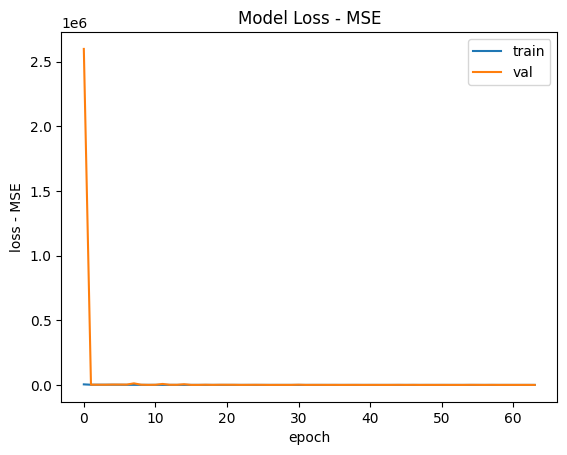

In [33]:
plot_loss(model_1_history, "loss")

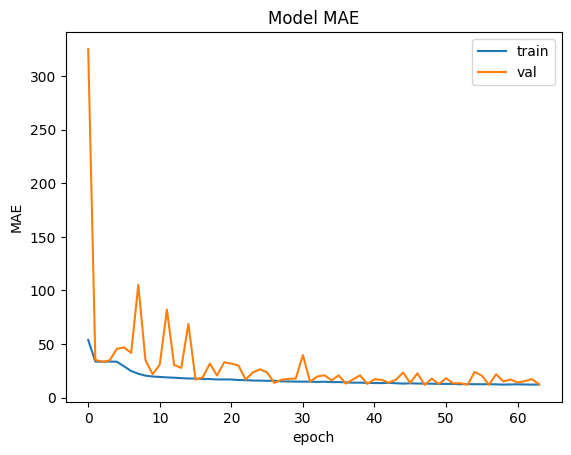

In [34]:
plot_MAE(model_1_history, "mean_absolute_error")

We evaluate the performances of the Inception_V4 on the test set

In [35]:
model_1_evaluation = model_1.evaluate(test_dataset, verbose="auto", steps=test_steps)
print("MSE on the Test = " + str(model_1_evaluation[0]))
print("MAE on the Test = " + str(model_1_evaluation[1]))

5/5 [==============================] - 11s 2s/step - loss: 228.3727 - mean_absolute_error: 12.3101
MSE on the Test = 228.37274169921875
MAE on the Test = 12.310079574584961


**DEMO**

In [36]:
test_x, test_y = next(test_dataset)
model_1.load_weights('InceptionV4.h5')
prediction = (model_1.predict(test_x, batch_size = 40, verbose = True))
test_months = (test_y)


for i in random.sample(range(len(test_x)), 4):
    print("image number: " + str(i))
    print("Age: " + str(test_months[i]))
    print(" Predicted Age: " + str(prediction[i]))


1/1 [==============================] - 3s 3s/step
image number: 38
Age: 163.80025106008145
 Predicted Age: [148.40688]
image number: 23
Age: 148.81053033070683
 Predicted Age: [135.61702]
image number: 29
Age: 11.213674589225533
 Predicted Age: [53.342827]
image number: 14
Age: 149.10041266311168
 Predicted Age: [136.91563]
